# Dorothea

There are two ways of describing the city of Dorothea: you can say that four aluminum towers rise from its walls flanking seven gates with spring-operated drawbridges that span the moat whose water feeds four green canals which cross the city, dividing it into nine quarters, each with three hundred houses and seven hundred chimneys. And bearing in mind that the nubile girls of each quarter marry youths of other quarters and their parents exchange the goods that each family holds in monopoly -- bergamot, sturgeon roe, astrolabes, amethysts -- you can then work from these facts until you learn everything you wish about the city in the past, present, and future. Or else you can say, like the camel driver who took me there: “I arrived here in my first youth, one morning, many people were hurrying along the streets toward the market, the women had fine teeth and looked you straight in the eye, three soldiers on a platform played the trumpet, and all around wheels turned and colored banners fluttered in the wind. Before then I had known only the desert and the caravan routes. In the years that followed, my eyes returned to contemplate the desert expanses and the caravan routes; but now I know this path is only one of the many that opened before me on that morning in Dorothea.”

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

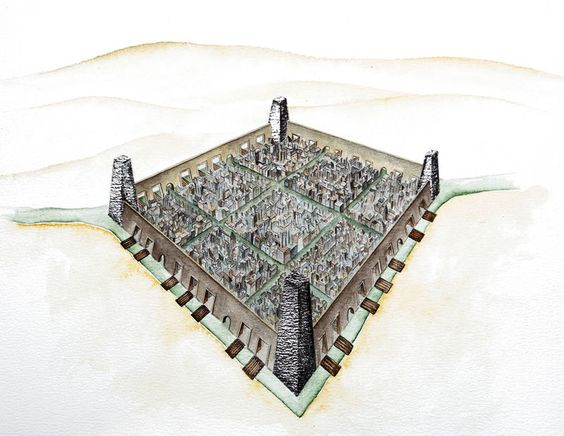

In [4]:
Image(filename='../Images/Dorothea.jpg') 

## DOROTEA

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [6]:
from PlotUtil import *
from Util import *
from PandaUtil import *

In [7]:
import FEParam as FP

In [8]:
from scipy import signal as SGN

In [9]:
import logging
import sys

# Get root logger (all other loggers will be derived from this logger's
# properties)
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout

### Nominal calibration constant (adc_per_pes)

http://localhost:8989/notebooks/SIERPE.ipynb

In [10]:
adc_to_pes = 18.07  # in the MC this is fixed for all PMTs, in data it comes from calibration

In [634]:
h5f = tb.open_file('../../data/Na/WF_Na_test_RWF.h5', "r+")

In [635]:
h5f

File(filename=../../data/Na/WF_Na_test_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=9, complib='blosc', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/BLR (Group) ''
/BLR/acum (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 8192)
/BLR/mau (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 8192)
/BLR/pulse_on (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/BLR/wait_over (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)

In [12]:
 pmt_t = h5f.root.Sensors.DataPMT

In [13]:
PMT = read_data_sensors(pmt_t)

In [14]:
PMT

,active,adc_to_pes,channel,gain,x,y
0,1,20.0,0,4500000.0,23.9414,65.7785
1,1,20.0,1,4500000.0,-68.9365,-12.1554
2,1,20.0,2,4500000.0,44.9951,-53.6231
3,1,20.0,3,4500000.0,0.0000,185.0000
4,1,20.0,5,4500000.0,-118.9160,141.7180
5,1,20.0,6,4500000.0,-182.1890,32.1249
6,1,20.0,8,4500000.0,-160.2150,-92.5000
7,1,20.0,9,4500000.0,-63.2737,-173.8430
8,1,20.0,10,4500000.0,63.2737,-173.8430
9,1,20.0,12,4500000.0,160.2150,-92.5000


In [15]:
PMT['adc_to_pes'] = adc_to_pes

In [16]:
PMT

,active,adc_to_pes,channel,gain,x,y
0,1,18.07,0,4500000.0,23.9414,65.7785
1,1,18.07,1,4500000.0,-68.9365,-12.1554
2,1,18.07,2,4500000.0,44.9951,-53.6231
3,1,18.07,3,4500000.0,0.0000,185.0000
4,1,18.07,5,4500000.0,-118.9160,141.7180
5,1,18.07,6,4500000.0,-182.1890,32.1249
6,1,18.07,8,4500000.0,-160.2150,-92.5000
7,1,18.07,9,4500000.0,-63.2737,-173.8430
8,1,18.07,10,4500000.0,63.2737,-173.8430
9,1,18.07,12,4500000.0,160.2150,-92.5000


##### NB The value of adc_to_pes in changed in the temporary DF, not in file

In [17]:
pmtcwf = h5f.root.RD.pmtcwf

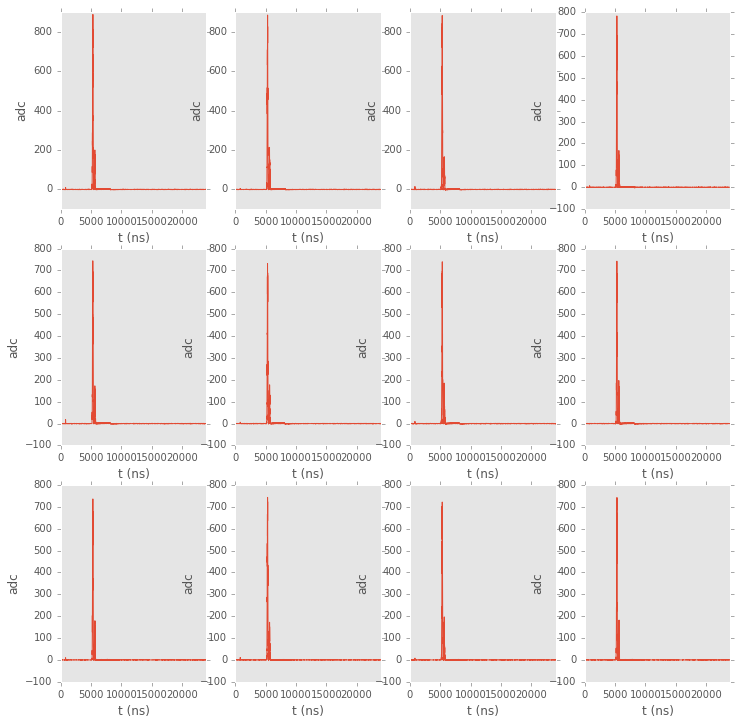

Press a key...


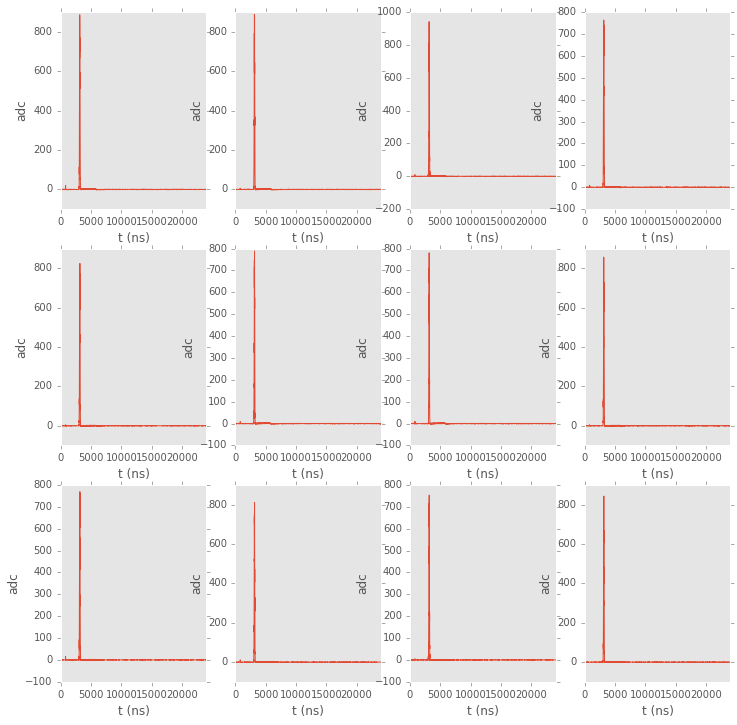

Press a key...


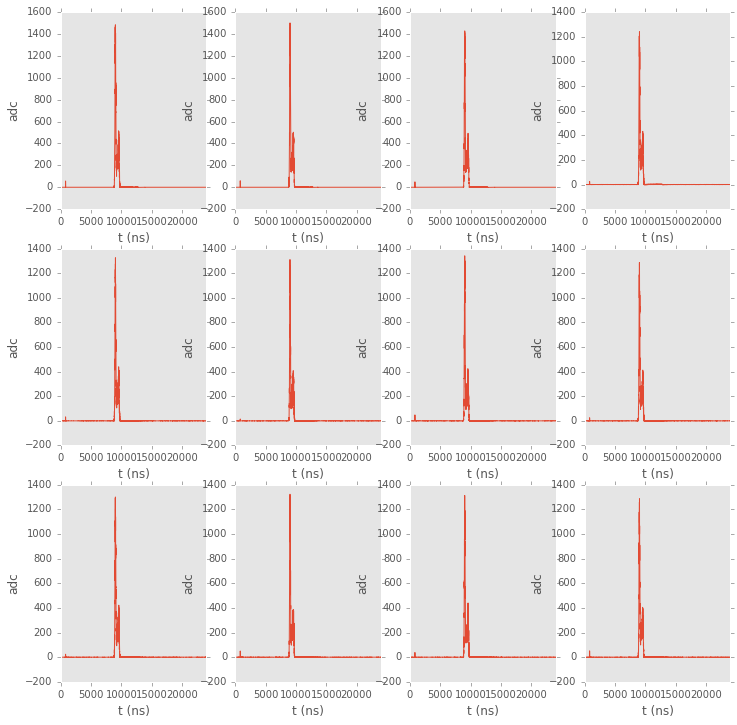

Press a key...


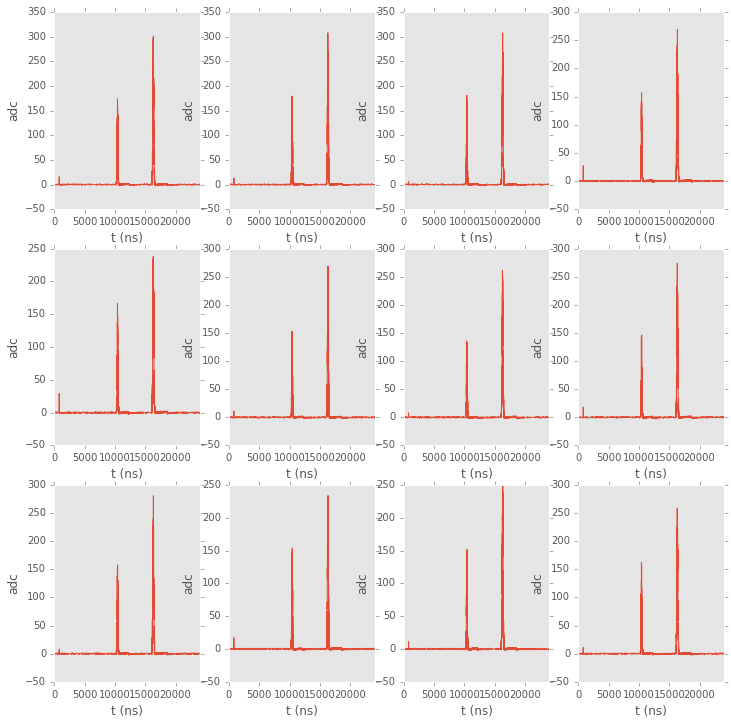

Press a key...


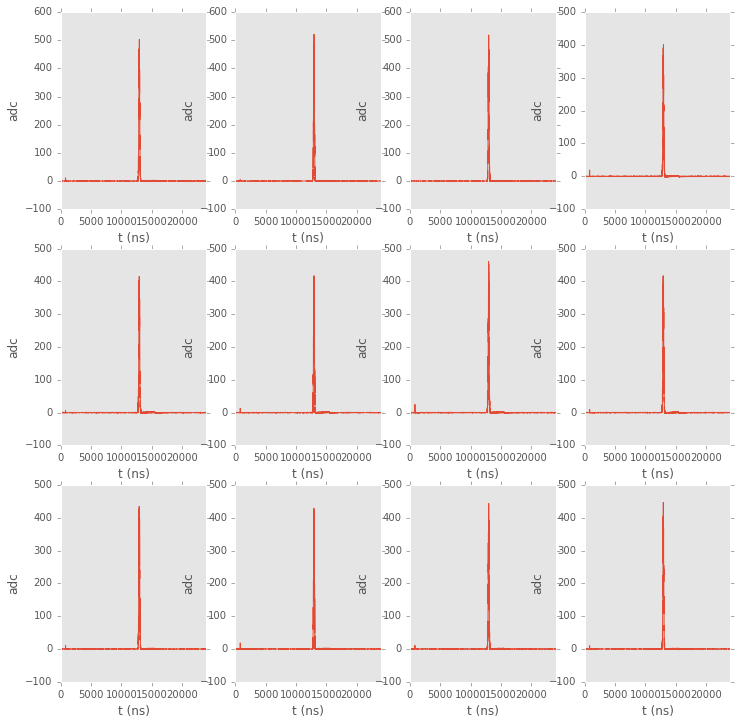

Press a key...


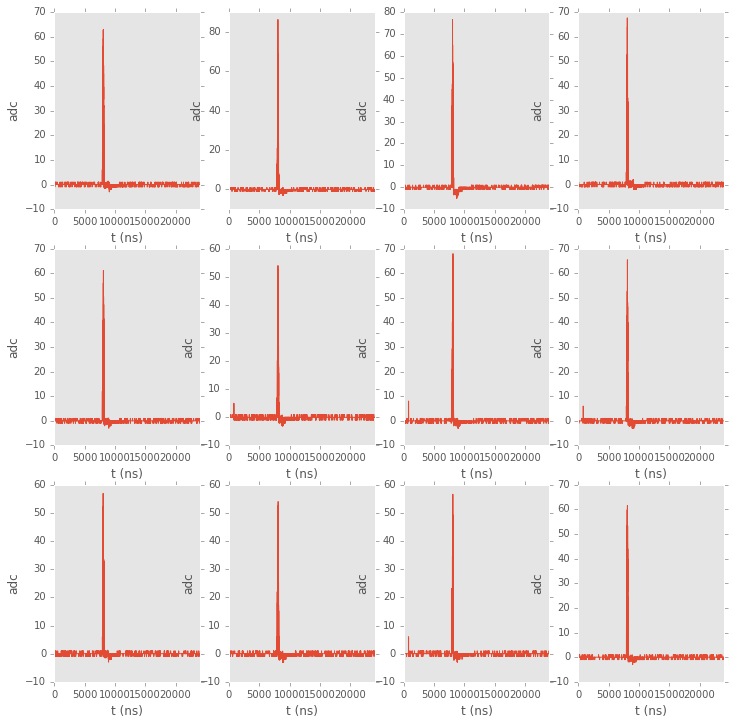

Press a key...


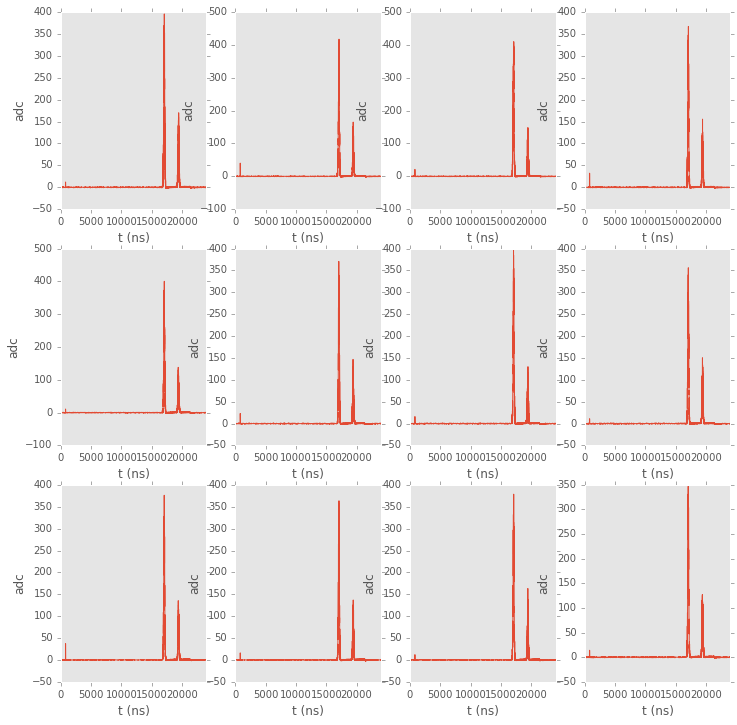

Press a key...


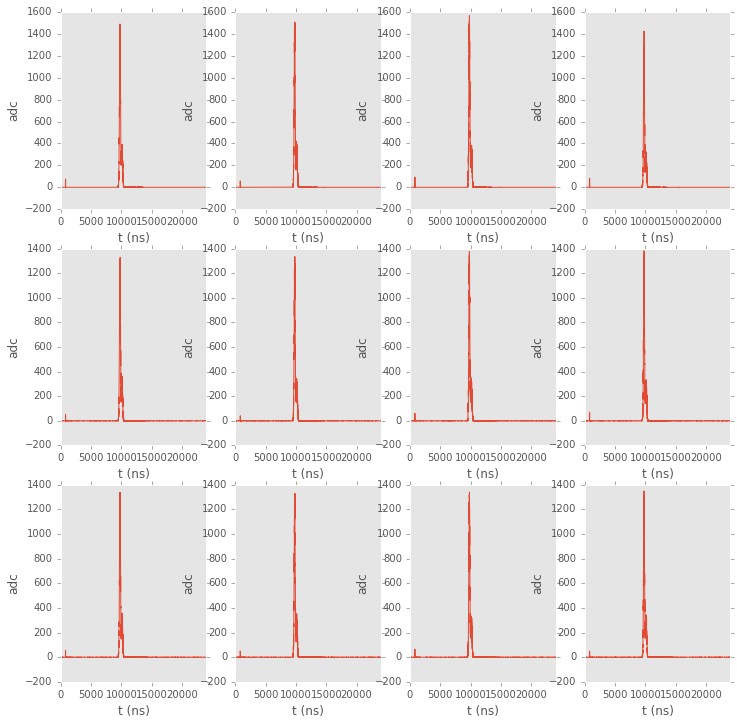

Press a key...


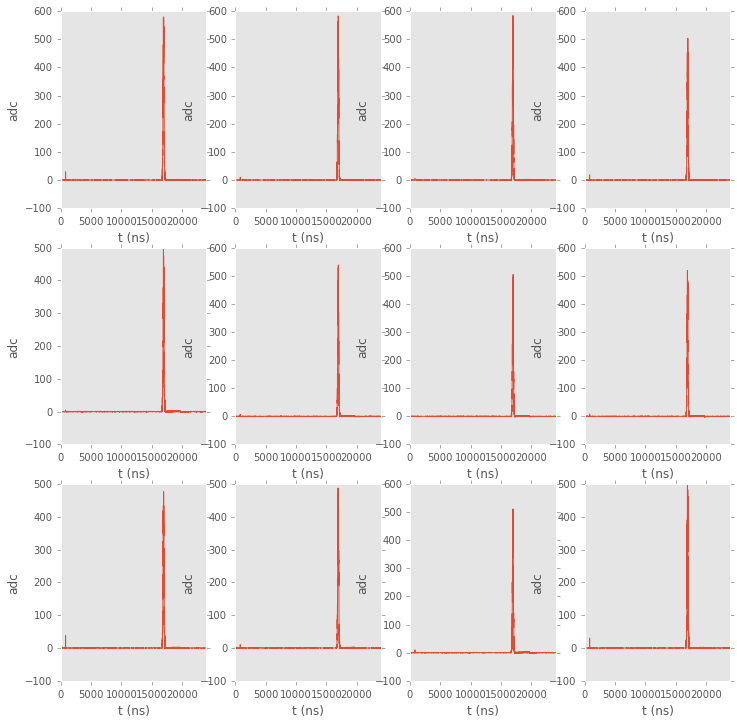

Press a key...


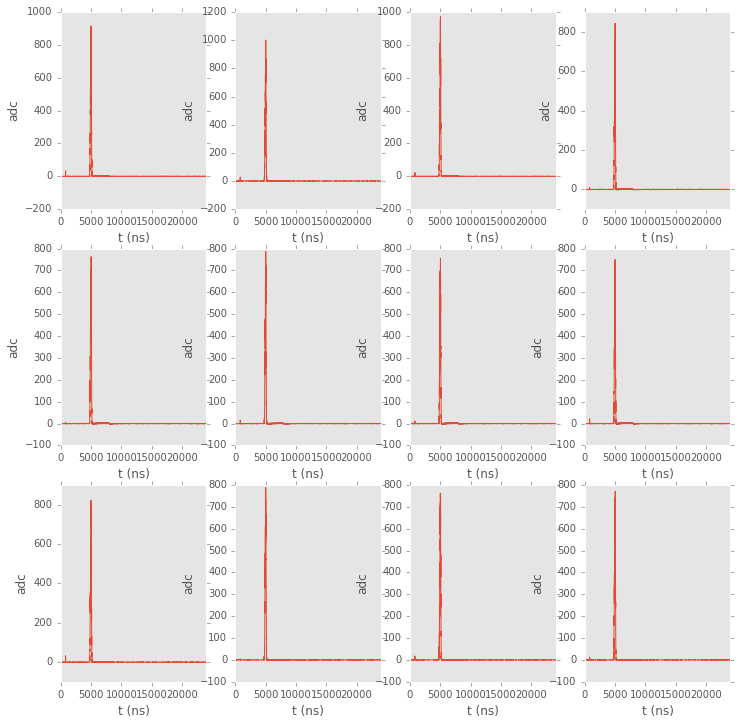

Press a key...


In [18]:
scan_waveforms(pmtcwf,list_of_events=range(10))

### Adding waveforms (calibrated)

#### add_cwf adds the waveform of each PMT in PES (divide by calibration constant) and returns a data frame

In [482]:
def wfdf(time_ns,energy_pes,indx):
    swf = {}
    swf['time_ns'] = time_ns
    swf['ene_pes'] = energy_pes 
    swf['indx'] = indx
    return pd.DataFrame(swf)

In [483]:
def add_cwf(cwfdf,pmtDF):
    """
    input: cwfdf: each colum is the wf for one PMT.
    output: swf is a data frame with two columns:
    time_ns = counts the time in ns
    ene_pes = conths the energy in pes
    """
    wf =0
    NPMT = len(pmtDF)
    for i in range(NPMT):
        adc_to_pes = pmtDF['adc_to_pes'][i]
        wf += cwfdf[i].values/adc_to_pes
    
    return wfdf(np.array(range(len(wf)))*FP.time_DAQ, wf,np.array(range(len(wf))))
    #swf = {}
    #swf['time_ns'] = np.array(range(len(wf)))*FP.time_DAQ  # time in ns
    #swf['ene_pes'] = wf 
    #swf['indx'] = np.array(range(len(wf)))
    #return pd.DataFrame(swf)

In [484]:
cwfdf = get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)

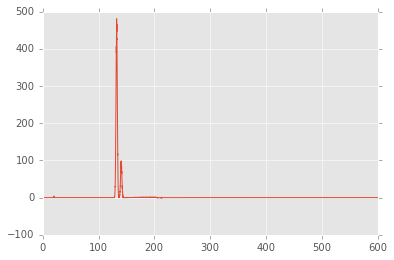

In [485]:
plt.plot(swf['time_ns']/mus, swf['ene_pes'])

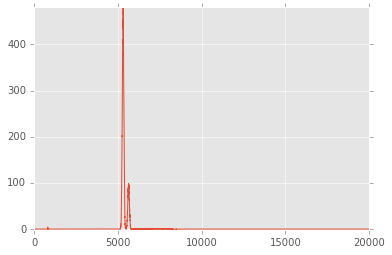

In [486]:
plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

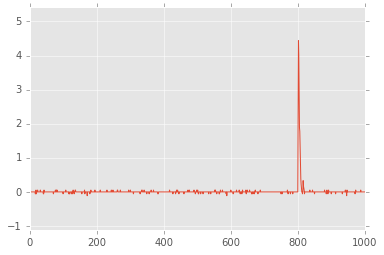

In [487]:
plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

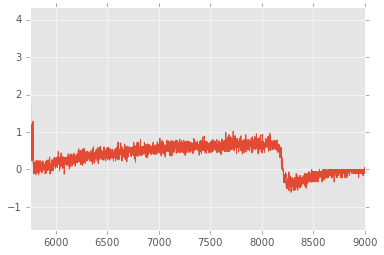

In [488]:
plts(swf['ene_pes'], signal_start=5750, signal_end=9000, offset=1)

In [489]:
sum(swf['ene_pes'].values)

65629.899866195788

In [490]:
cwfdf = get_waveforms(pmtcwf,event_number=1)
swf = add_cwf(cwfdf,PMT)

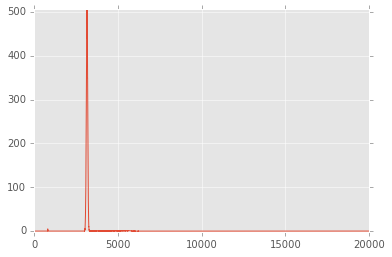

In [491]:
plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

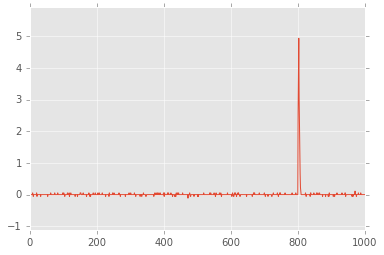

In [492]:
plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

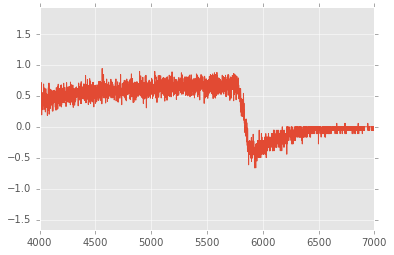

In [493]:
plts(swf['ene_pes'], signal_start=4000, signal_end=7000, offset=1)

In [494]:
cwfdf = get_waveforms(pmtcwf,event_number=2)
swf = add_cwf(cwfdf,PMT)

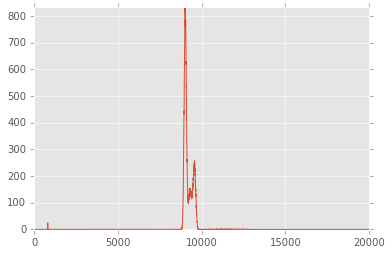

In [495]:
plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

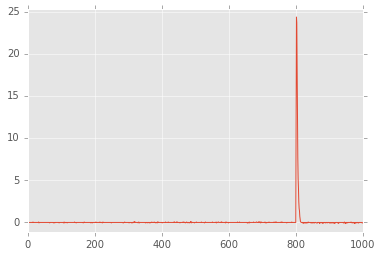

In [496]:
plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

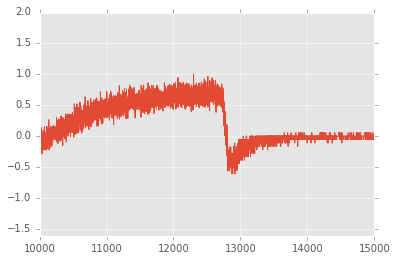

In [497]:
plts(swf['ene_pes'], signal_start=10000, signal_end=15000, offset=1)

In [498]:
cwfdf = get_waveforms(pmtcwf,event_number=3)
swf = add_cwf(cwfdf,PMT)

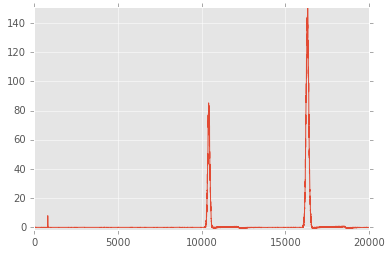

In [499]:
plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

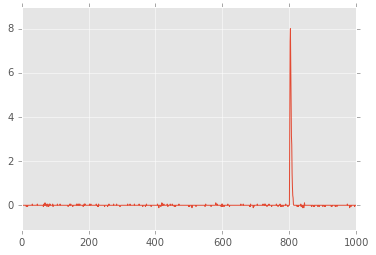

In [500]:
plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

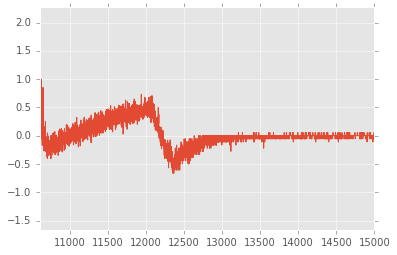

In [501]:
plts(swf['ene_pes'], signal_start=10600, signal_end=15000, offset=1)

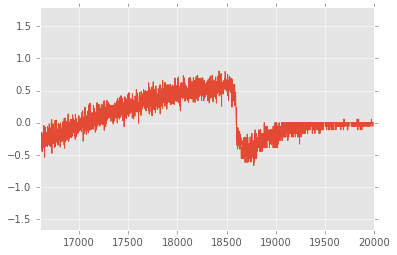

In [502]:
plts(swf['ene_pes'], signal_start=16600, signal_end=20000, offset=1)

In [503]:
swf

,ene_pes,indx,time_ns
0,0.00000,0,0.0
1,0.00000,1,25.0
2,0.00000,2,50.0
3,0.00000,3,75.0
4,0.00000,4,100.0
5,0.00000,5,125.0
6,0.00000,6,150.0
7,0.00000,7,175.0
8,0.00000,8,200.0
9,0.00000,9,225.0


#### Effect of baseline recovery

Tipically a jump -0.5 to 0.5 then again to 0. A threshold of 1 pes should get rid of the effect. Rebinning must be done after ZS and splitting the WF in S1 and S2s, to avoid amplifying the effect. 

In [47]:
def scan_SWF(pmtcwf,pmtDF,list_of_events=[0]):
    for event in list_of_events:
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        plt.plot(swf['time_ns']/mus, swf['ene_pes'])
        plt.show()
        wait()
  

#### The problem with rebinning

Baseline recovery is a sistematic effect that is exagerated by rebinning. In the swf the baseline recovers in 1 pes, the rebinned wf recovers in 40 pes. 

### Finding S1 and S2 signals

In [48]:
def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]
    

In [353]:
def find_S12(swf, stride=40):
    T = swf['time_ns'].values
    P = swf['ene_pes'].values
    I = swf['indx'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(swf)) :
        if swf.index[i]-stride > swf.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        S12L.append(pd.DataFrame(S12[i], columns=['time_ns','ene_pes','indx']))
    return S12L
            

In [ ]:
NPMT = len(PMT)
adc_to_pes = PMT['adc_to_pes'][0]
nsigma=5
thr = nsigma*sqrt(NPMT)*rebin*FP.NOISE_ADC/adc_to_pes
thr = nsigma*FP.NOISE_ADC/adc_to_pes

In [50]:
thr = 2 # to take into account BLR threshold recovery

In [354]:
cwfdf = get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)
swf_zs = wf_thr(swf,threshold=thr)

In [355]:
swf_zs = wf_thr(swf,threshold=thr)

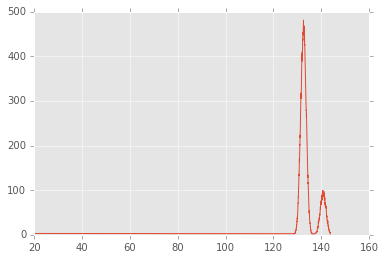

In [356]:
plt.plot(swf_zs['time_ns']/mus, swf_zs['ene_pes'])

In [357]:
s12 = find_S12(swf_zs)

In [358]:
len(s12)

2

In [359]:
s1 = s12[0]
s2 = s12[1]

In [360]:
s1

,time_ns,ene_pes,indx
0,20025.0,2.326433,801
1,20050.0,4.436610,802
2,20075.0,4.000255,803
3,20100.0,3.007150,804


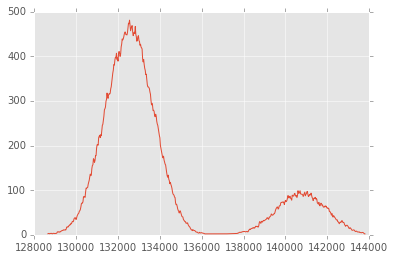

In [362]:
plt.plot(s2['time_ns'], s2['ene_pes'])

In [363]:
cwfdf = get_waveforms(pmtcwf,event_number=3)
swf = add_cwf(cwfdf,PMT)
swf_zs = wf_thr(swf,threshold=thr)

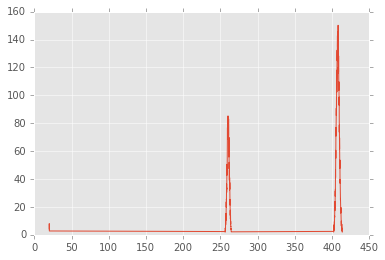

In [364]:
plt.plot(swf_zs['time_ns']/mus, swf_zs['ene_pes'])

In [365]:
s12 = find_S12(swf_zs)

In [366]:
len(s12)

3

In [367]:
s1=s12[0]
s2_1=s12[1]
s2_2=s12[2]

In [368]:
s1

,time_ns,ene_pes,indx
0,20025.0,4.211229,801
1,20050.0,7.431820,802
2,20075.0,7.998556,803
3,20100.0,6.179889,804
4,20125.0,4.194451,805
5,20150.0,3.132792,806
6,20175.0,2.743456,807


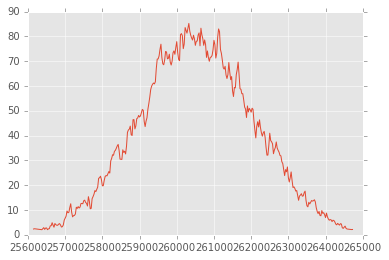

In [369]:
 plt.plot(s2_1['time_ns'],s2_1['ene_pes'])

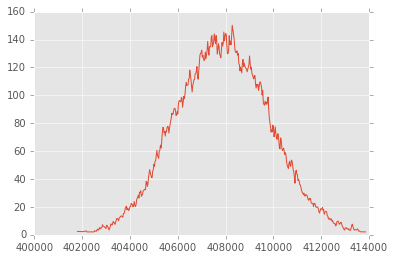

In [370]:
plt.plot(s2_2['time_ns'],s2_2['ene_pes'])

In [371]:
thr=2
stride = 40
cwfdf = get_waveforms(pmtcwf,event_number=2)
swf = add_cwf(cwfdf,PMT)
swf_zs = wf_thr(swf,threshold =thr)
s12 = find_S12(swf_zs, stride=stride)

In [372]:
len(s12)

2

In [373]:
s1 = s12[0]
s2 = s12[1]

In [374]:
s1

,time_ns,ene_pes,indx
0,20025.0,11.973560,801
1,20050.0,24.411607,802
2,20075.0,23.732749,803
3,20100.0,18.063477,804
4,20125.0,12.213586,805
5,20150.0,7.743836,806
6,20175.0,5.197178,807
7,20200.0,4.036626,808
8,20225.0,2.435279,809


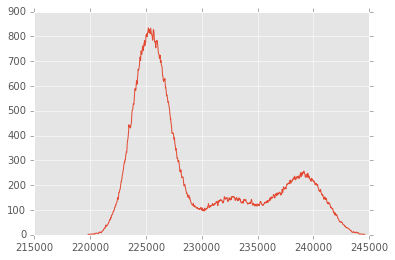

In [375]:
plt.plot(s2['time_ns'], s2['ene_pes'])

In [376]:
def s12_list(pmtcwf,pmtDF,list_of_events=[0], thr = 2, stride=40):
    """
    1) adds the waveforms (calibrated)
    3) Supresses zeros
    4) finds s1 and s2 objects (with a stride of 1 mus and a threshold of 2 pes)
    """
    
    S12 =[]
    for event in list_of_events:
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        swf_zs = wf_thr(swf,threshold =thr)
        s12 = find_S12(swf_zs, stride=stride)
        S12.append(s12)
    return S12
        
        

In [377]:
s12l = s12_list(pmtcwf,PMT,list_of_events=range(10), thr = 2, stride=40)

In [159]:
def scan_S12(s12l):
    """
    Plots S1 and S2 for each S12
    """
    
    for s12 in s12l:
        print("number of s12 signals = {}".format(len(s12)))
        s1 = s12[0] #s1 is a series
        print("s1 = {}".format(s1))
        
        for s2 in s12[1:]:
            plt.plot(s2['time_ns'],s2['ene_pes'])
        plt.show()
        wait()

number of s12 signals = 2
s1 =    time_ns   ene_pes
0  20025.0  2.326433
1  20050.0  4.436610
2  20075.0  4.000255
3  20100.0  3.007150


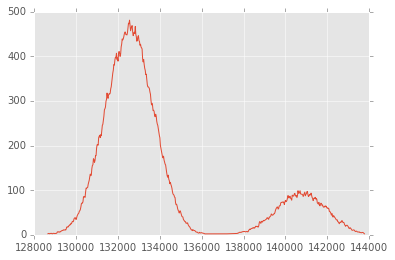

Press a key...
number of s12 signals = 2
s1 =    time_ns   ene_pes
0  20025.0  2.602900
1  20050.0  3.825369
2  20075.0  4.938516
3  20100.0  3.061546
4  20125.0  2.227087


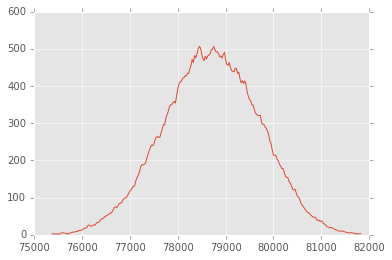

Press a key...
number of s12 signals = 2
s1 =    time_ns    ene_pes
0  20025.0  11.973560
1  20050.0  24.411607
2  20075.0  23.732749
3  20100.0  18.063477
4  20125.0  12.213586
5  20150.0   7.743836
6  20175.0   5.197178
7  20200.0   4.036626
8  20225.0   2.435279


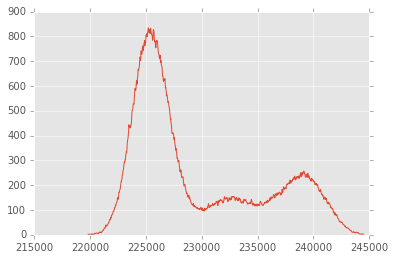

Press a key...
number of s12 signals = 3
s1 =    time_ns   ene_pes
0  20025.0  4.211229
1  20050.0  7.431820
2  20075.0  7.998556
3  20100.0  6.179889
4  20125.0  4.194451
5  20150.0  3.132792
6  20175.0  2.743456


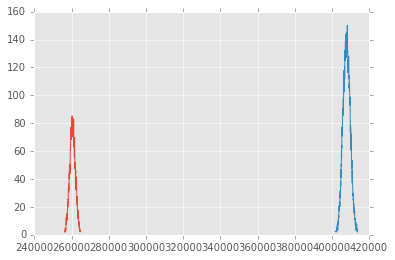

Press a key...
number of s12 signals = 2
s1 =    time_ns   ene_pes
0  20025.0  2.769773
1  20050.0  5.489169
2  20075.0  6.385040
3  20100.0  4.566218
4  20125.0  3.176257
5  20150.0  2.570747


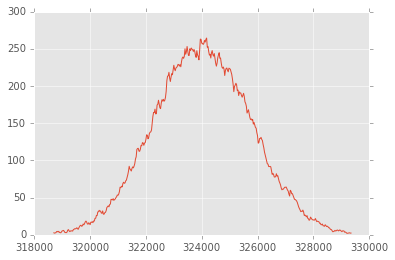

Press a key...
number of s12 signals = 1
s1 =       time_ns   ene_pes
0    198350.0  2.051009
1    198400.0  2.442025
2    198425.0  2.221415
3    198600.0  2.606357
4    198625.0  2.554882
5    198650.0  2.669162
6    198675.0  2.334797
7    198700.0  2.667573
8    198725.0  3.447852
9    198750.0  3.335129
10   198775.0  3.174062
11   198800.0  4.615520
12   198825.0  4.287427
13   198850.0  4.014745
14   198875.0  4.069458
15   198900.0  3.853767
16   198925.0  2.958642
17   198950.0  3.010424
18   198975.0  4.179186
19   199000.0  4.331329
20   199025.0  4.220839
21   199050.0  3.448248
22   199075.0  3.341363
23   199100.0  2.841781
24   199125.0  3.007464
25   199150.0  4.379749
26   199175.0  6.548601
27   199200.0  4.950801
28   199225.0  5.566389
29   199250.0  5.233873
..        ...       ...
228  204225.0  6.639969
229  204250.0  5.534774
230  204275.0  5.591825
231  204300.0  6.591391
232  204325.0  5.874142
233  204350.0  5.599111
234  204375.0  5.656235
235  204400.0  6.2

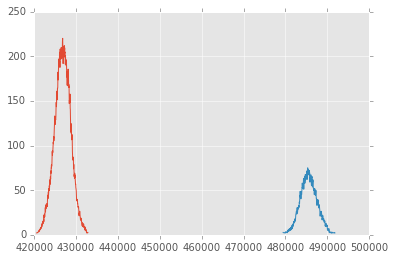

Press a key...
number of s12 signals = 2
s1 =     time_ns    ene_pes
0   20025.0  17.739328
1   20050.0  35.398272
2   20075.0  36.345937
3   20100.0  34.079888
4   20125.0  26.099993
5   20150.0  18.716078
6   20175.0  13.980294
7   20200.0   8.626541
8   20225.0   5.480980
9   20250.0   3.777153
10  20275.0   2.768966


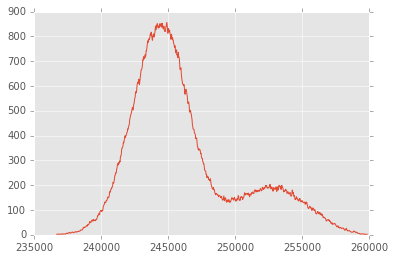

Press a key...
number of s12 signals = 2
s1 =    time_ns   ene_pes
0  20025.0  3.935439
1  20050.0  7.988512
2  20075.0  7.336467
3  20100.0  5.017653
4  20125.0  4.688860
5  20150.0  3.084266
6  20175.0  2.084831


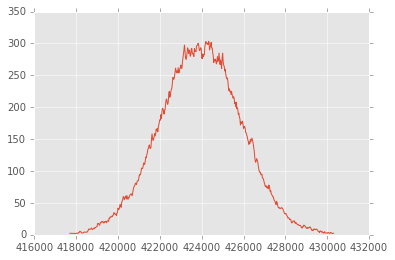

Press a key...
number of s12 signals = 2
s1 =    time_ns   ene_pes
0  20025.0  5.597707
1  20050.0  9.986353
2  20075.0  9.448898
3  20100.0  7.801983
4  20125.0  6.250508
5  20150.0  4.597746
6  20175.0  2.775812


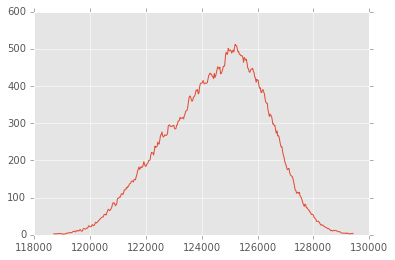

Press a key...


In [153]:
scan_S12(s12l)

### Rebinning waveforms

No need to rebin S1, enough to rebin S2

In [422]:
def rebin_waveform(swf, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    t = swf['time_ns'].values
    e = swf['ene_pes'].values
    I = swf['indx'].values
    n = len(swf)/int(stride)
    r = len(swf)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb)
    E = np.zeros(lenb)
    II = np.zeros(lenb, dtype=int)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        II[i] = I[(j+stride)/2]
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
        II[n] = I[(len(swf) - j/2)]
    
   
    rbw={}
    rbw['ene_pes'] = E
    rbw['time_ns'] = T
    rbw['indx'] = II
    return pd.DataFrame(rbw)
    

In [423]:
len(s12l)

10

In [424]:
s12=s12l[1]

In [425]:
len(s12)

2

In [426]:
s1 = s12[0]
s2 = s12[1]

In [427]:
s1

,time_ns,ene_pes,indx
0,20025.0,2.602900,801
1,20050.0,3.825369,802
2,20075.0,4.938516,803
3,20100.0,3.061546,804
4,20125.0,2.227087,805


In [428]:
def find_t0(s1):
    """
    returns t0
    """
    emax = np.amax(s1.ene_pes.values)
    return s1.loc[lambda df: df.ene_pes.values ==emax, :]

In [429]:
t0 = find_t0(s1)

In [430]:
t0

,time_ns,ene_pes,indx
2,20075.0,4.938516,803


In [431]:
rbs2 = rebin_waveform(s2, stride = 40)

In [432]:
rbs2

,ene_pes,indx,time_ns
0,496.157097,3035,75862.5
1,4192.382725,3055,76862.5
2,13812.314447,3075,77862.5
3,18804.768699,3095,78862.5
4,10784.758631,3115,79862.5
5,2191.461805,3135,80862.5
6,114.233661,3155,81612.5


In [252]:
def s2_energy(s2):
    """
    total energy in pes
    """
    return np.sum(s2.ene_pes.values)

In [253]:
s2_energy(rbs2)

50394.068220469933

In [254]:
def s2_length(s2):
    """
    s2 length in ns
    """
    t = s2.time_ns.values
    return t[-1] - t[0]
   

In [255]:
s2_length(rbs2)/mus

5.7374999999999998

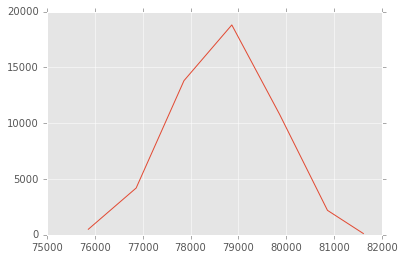

In [433]:
plt.plot(rbs2.time_ns.values,rbs2.ene_pes.values)

In [279]:
def S12(s12l):
    """
    computes s1, rebins S2
    """
    
    print("list s12l has length = {}".format(len(s12l)))
    j= 0
    EPL =[]
    
    for s12 in s12l:
        EP = {}
        print('event number {}'.format(j))
        #print("number of s12 signals = {}".format(len(s12)))
        ll=0
        if len(s12) > 1:
            s1 = s12[0] #s1 is a series
            #print("s1 = {}".format(s1))
            t0 = find_t0(s1)
            #print("t0 = {}".format(t0))
            EP['t0_mus'] = t0.time_ns.values[0]/mus
            ll=1
        else:
            print('no S1 found')
            EP['t0_mus'] = -999
        
        k = 0
        epes = 0
        lmax = 0
        for s2 in s12[ll:]:
            #print('s2 number {}'.format(k))
            rbs2 = rebin_waveform(s2, stride = 40)
            #print("s2 = {}".format(rbs2))
            es2 = s2_energy(rbs2)
            ls2 = s2_length(rbs2)
            #print("energy (pes) = {} length (mus) = {}".format(es2,ls2/mus))
            epes += es2
            if ls2 > lmax:
                lmax = ls2
            k+=1
        
        EP['n_s2'] =k
        EP['ene_pes'] = epes
        EP['lmax_mus'] = lmax/mus 
        EPL.append(EP)
        j+=1
    return pd.DataFrame(EPL)
    

In [281]:
s12df = S12(s12l)

list s12l has length = 10
event number 0
event number 1
event number 2
event number 3
event number 4
event number 5
no S1 found
event number 6
event number 7
event number 8
event number 9


In [282]:
s12df

,ene_pes,lmax_mus,n_s2,t0_mus
0,64487.368264,14.277500,1,20.050
1,50394.068220,5.737500,1,20.075
2,217719.809295,23.701667,1,20.050
3,39923.685553,10.770882,2,20.075
4,44537.576735,9.818500,1,20.075
5,3560.002489,5.736875,1,-999.000
6,53849.558823,10.999286,2,20.075
7,229459.363572,22.580000,1,20.075
8,58005.281235,11.694375,1,20.050
9,86355.358502,9.815625,1,20.050


In [293]:
t0_zs = s12df.loc[lambda df: df.t0_mus.values >=0, :]

In [294]:
t0_zs

,ene_pes,lmax_mus,n_s2,t0_mus
0,64487.368264,14.277500,1,20.050
1,50394.068220,5.737500,1,20.075
2,217719.809295,23.701667,1,20.050
3,39923.685553,10.770882,2,20.075
4,44537.576735,9.818500,1,20.075
6,53849.558823,10.999286,2,20.075
7,229459.363572,22.580000,1,20.075
8,58005.281235,11.694375,1,20.050
9,86355.358502,9.815625,1,20.050


In [291]:
def histo_S12(s12df, nbins=10):
    """
    histograms for s12 DF
    """
    HSimple1(s12df.ene_pes,nbins,title='energy pes',xlabel = 'ene')
    HSimple1(s12df.lmax_mus,nbins,title='track  length (mus)',xlabel = 'lmax (mus)')
    HSimple1(s12df.n_s2,nbins,title='number of S2',xlabel = 'n S2')
    HSimple1(s12df.t0_mus,nbins,title='t0',xlabel = 't (mus)')
    
    plt.show()
    

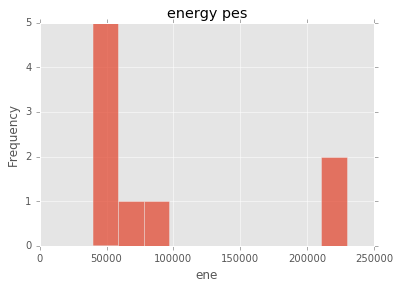

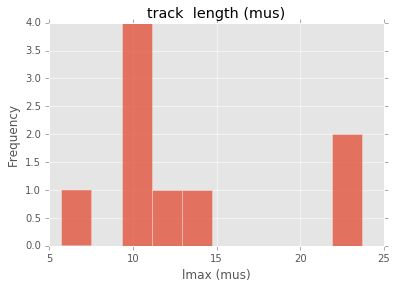

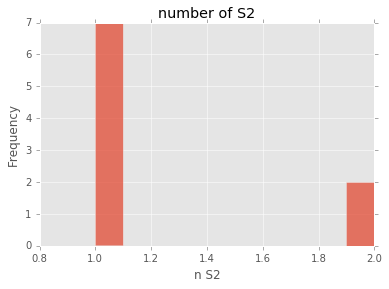

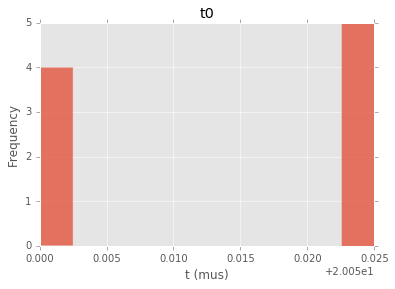

In [295]:
histo_S12(t0_zs, nbins=10)

### FEE PMAPS

Compute now the PMAPS in the EP.
A EP PMAP is defined as the collection of S2 (bins of 1 mus) in each PMT of the EP. The collection is built
using the s12l obtained with the sum PMT 

In [508]:
def pmt_wf(cwfdf,pmtDF):
    """
    input: cwfdf: each colum is the wf for one PMT.
    output: wf is a data frame with two columns:
    time_ns = counts the time in ns
    ene_pes = conths the energy in pes
    returns a data frame with one data frame per PMT
    each pmt DF expresses the waveform in the PMT
    """
    
    NPMT = len(pmtDF)
    PMTWF = []
    for i in range(NPMT):
        adc_to_pes = pmtDF['adc_to_pes'][i]
        wf = cwfdf[i].values/adc_to_pes
        PMTWF.append(wfdf(np.array(range(len(wf)))*FP.time_DAQ, wf,np.array(range(len(wf)))))
    
        
    return PMTWF

In [522]:
cwfdf = get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)
swf_zs = wf_thr(swf,threshold =thr)
s12 = find_S12(swf_zs, stride=stride)

In [517]:
pmtwf = pmt_wf(cwfdf,PMT)

In [518]:
len(pmtwf)

12

In [602]:
def scan_pmtwf(PMTWF):
    """
    Plots pmtwf
    """
    
    pmtwf = PMTWF[0]
    plt.plot(pmtwf['time_ns']/mus,pmtwf['ene_pes'])
    ene = pmtwf['ene_pes'].values/12.
    time = pmtwf['time_ns'].values/mus
    plt.xlabel('t (mus)')
    plt.ylabel('E (pes)')
    plt.show()
    plt.figure(figsize=(12,12))
    for i in range(1,len(PMTWF)):
        ax1 = plt.subplot(3,4,i)
        pmtwf = PMTWF[i]
        plt.plot(pmtwf['time_ns']/mus,pmtwf['ene_pes'])
        plt.plot(time,ene)
    
    plt.show()
     
    

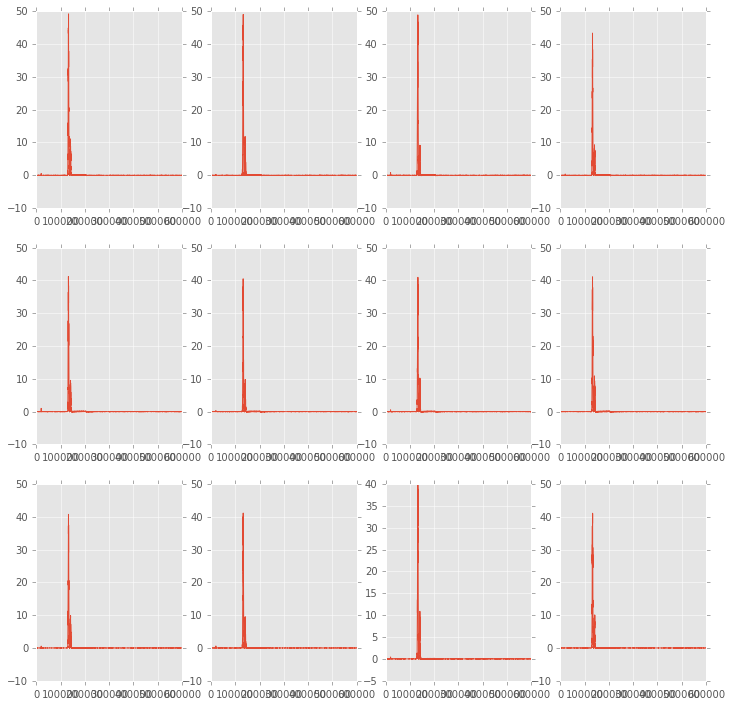

In [520]:
scan_pmtwf(pmtwf)

In [523]:
len(s12)

2

In [524]:
s2 = s12[1]

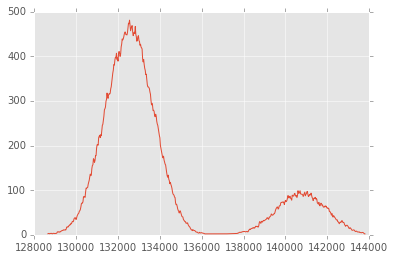

In [525]:
plt.plot(s2['time_ns'],s2['ene_pes'])

In [527]:
def scan_pmtwf_s2(PMTWF,s2):
    """
    Plots pmtwf
    """
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        pmtwf = PMTWF[i]
        plt.plot(pmtwf.time_ns.values[s2.indx.values[0]:s2.indx.values[-1]+1],
                 pmtwf.ene_pes.values[s2.indx.values[0]:s2.indx.values[-1]+1])
    
    plt.show()

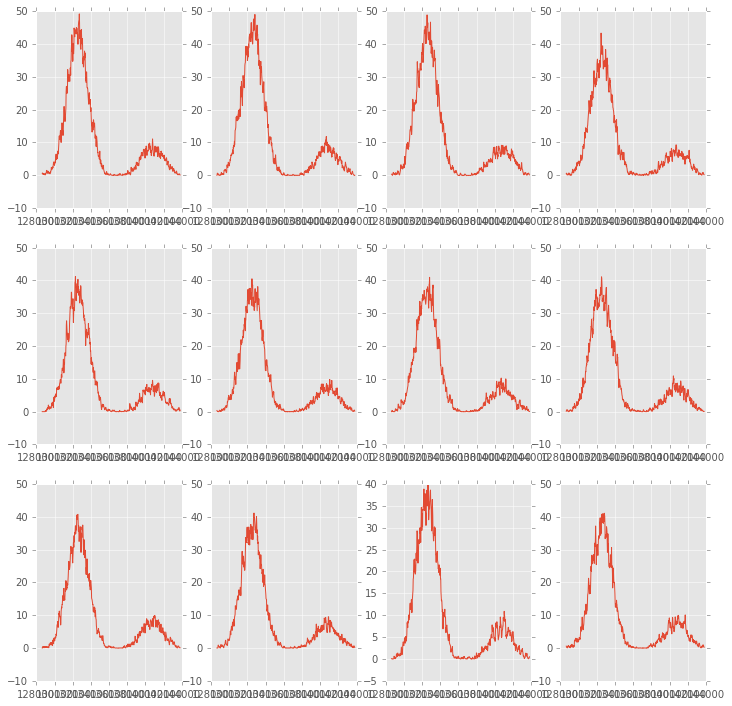

In [528]:
scan_pmtwf_s2(pmtwf,s2)

In [587]:
def pmaps_EP(pmtcwf,pmtDF,list_of_events=[0], thr = 2, stride=40):
    """
    computes pmaps in the EP plane
    """
    NPMT = len(pmtDF)
    S2PMAP = []
    for event in list_of_events:
        # compute the sum function (swf), supress zeros (swf_zs) and finds s12 for swf_zs
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        swf_zs = wf_thr(swf,threshold =thr)
        s12 = find_S12(swf_zs, stride=stride)
        
        is2=0
        if len(s12) > 1:  #if s1 exists is s12[0]
            is2=1  #s2 starts in index 1 if s1 exists in 0 otherwise
        
        S2L = []
        for s2 in s12[is2:]: #loop over s2 found is swf_zs
            PMTWF = pmt_wf(cwfdf,PMT) #wf for each of the PMTs
            #scan_pmtwf_s2(PMTWF,s2)
            
            PMAP = []
            s2rb = rebin_waveform(s2, stride = 40)
            PMAP.append(s2rb)
            for i in range(NPMT):
                pmtwf = PMTWF[i]
                pmtdf = wfdf(pmtwf.time_ns.values[s2.indx.values[0]:s2.indx.values[-1]+1], 
                                 pmtwf.ene_pes.values[s2.indx.values[0]:s2.indx.values[-1]+1],
                                 pmtwf.indx.values[s2.indx.values[0]:s2.indx.values[-1]+1])
                pmtrb = rebin_waveform(pmtdf, stride = 40)
                
                PMAP.append(pmtrb)
            S2L.append(PMAP)
        S2PMAP.append(S2L)
    return S2PMAP
                                 
            

In [588]:
s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=[0], thr = 2, stride=40)

In [589]:
len(s2pmap)

1

In [590]:
s2p = s2pmap[0]

In [591]:
len(s2p)

1

In [592]:
pmap = s2p[0]

In [593]:
len(pmap)

13

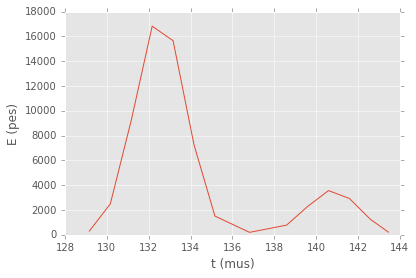

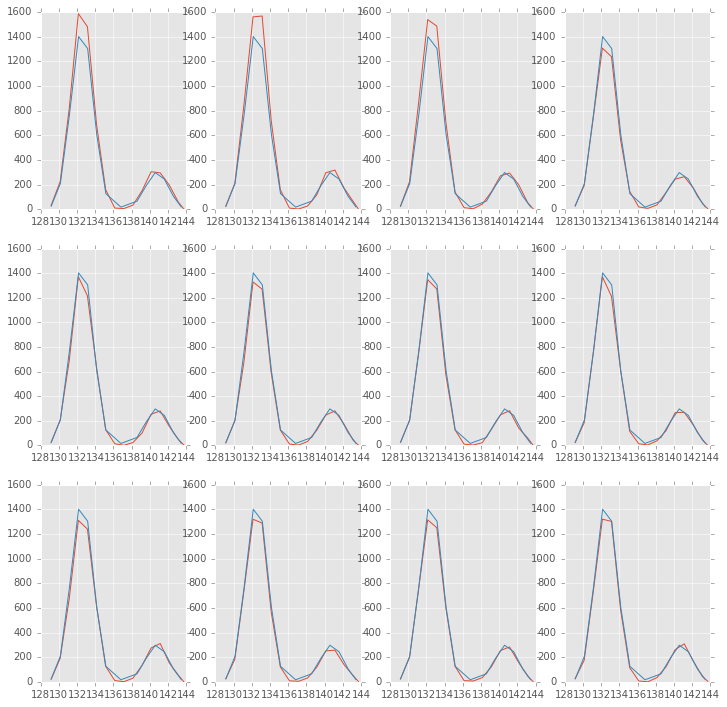

In [603]:
scan_pmtwf(pmap)

In [586]:
pmap[0]

,ene_pes,indx,time_ns
0,28.135262,5166,129137.5
1,223.256697,5186,130137.5
2,817.881391,5206,131137.5
3,1588.513360,5226,132137.5
4,1482.129170,5246,133137.5
5,689.466676,5266,134137.5
6,159.396214,5286,135137.5
7,8.844864,5306,136137.5
8,4.622064,5326,137137.5
9,32.371071,5346,138137.5


In [604]:
s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=range(5), thr = 2, stride=40)

In [605]:
len(s2pmap)

5

In [606]:
s2p = s2pmap[0]
len(s2p)

1

In [607]:
pmap = s2p[0]
len(pmap)

13

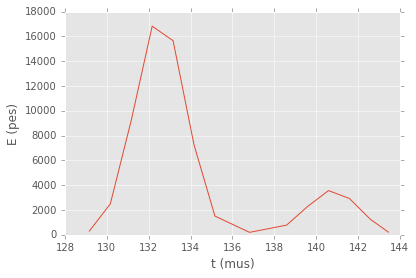

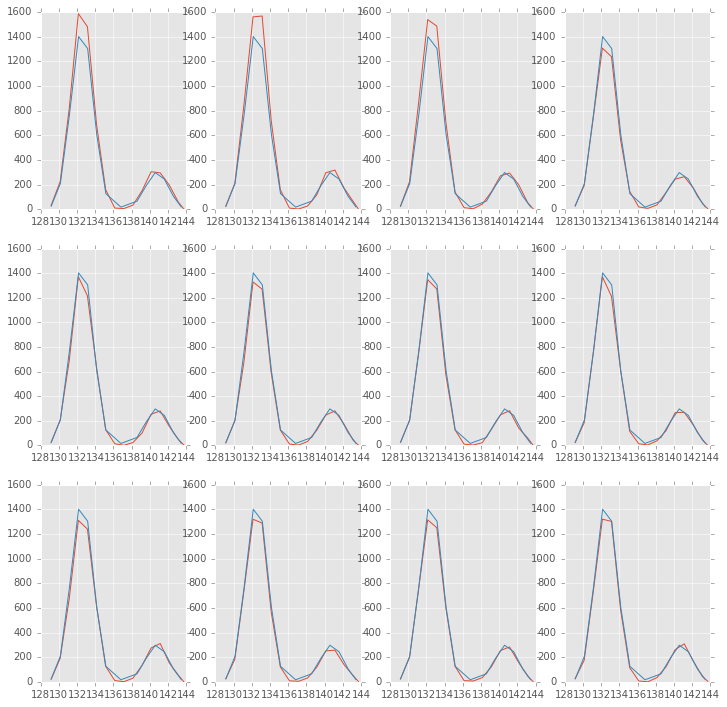

In [608]:
scan_pmtwf(pmap)

In [609]:
s2p = s2pmap[1]
len(s2p)

1

In [610]:
pmap = s2p[0]
len(pmap)

13

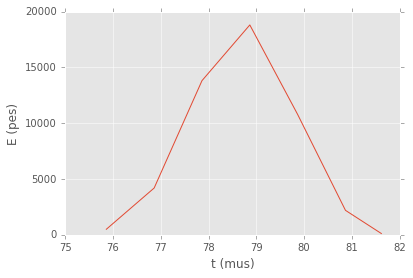

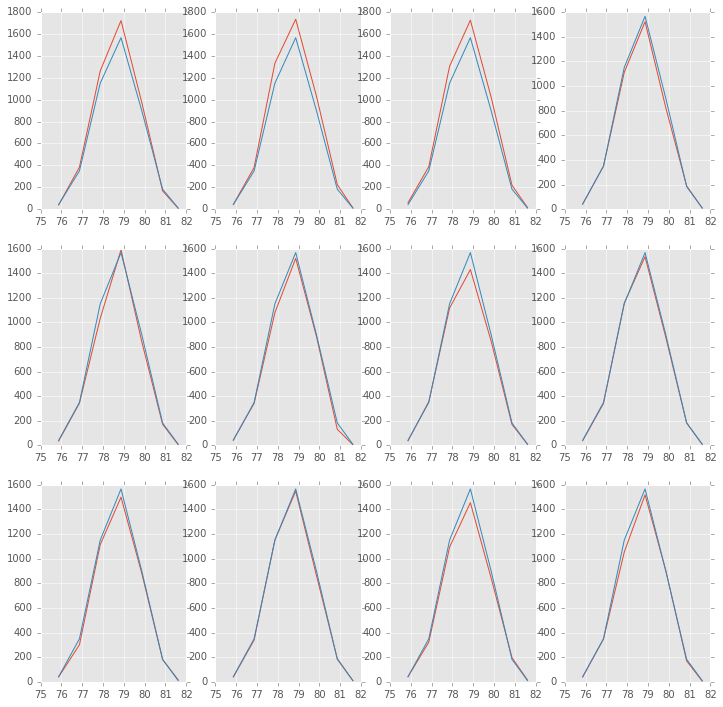

In [611]:
scan_pmtwf(pmap)

In [612]:
s2p = s2pmap[2]
len(s2p)

1

In [613]:
pmap = s2p[0]
len(pmap)

13

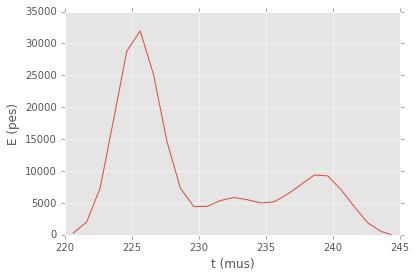

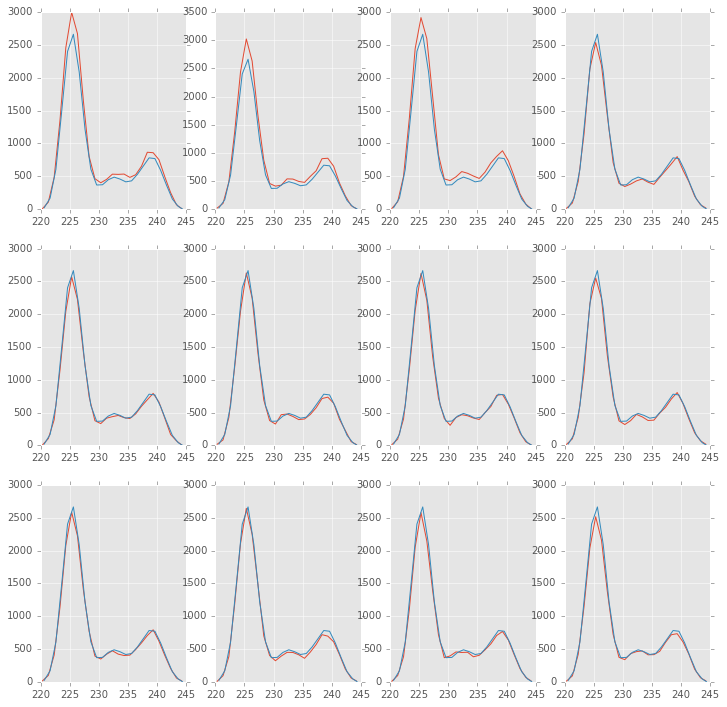

In [614]:
scan_pmtwf(pmap)

In [615]:
s2p = s2pmap[3]
len(s2p)

2

In [616]:
pmap = s2p[0]
len(pmap)

13

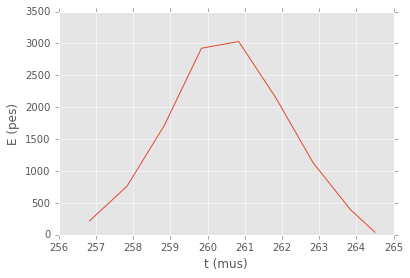

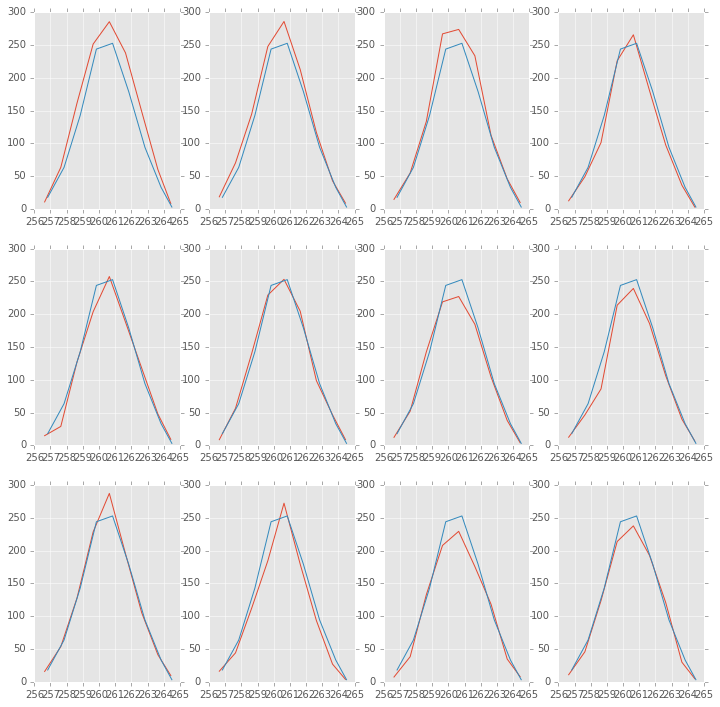

In [617]:
scan_pmtwf(pmap)

In [618]:
pmap = s2p[1]
len(pmap)

13

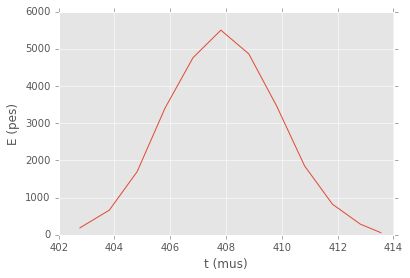

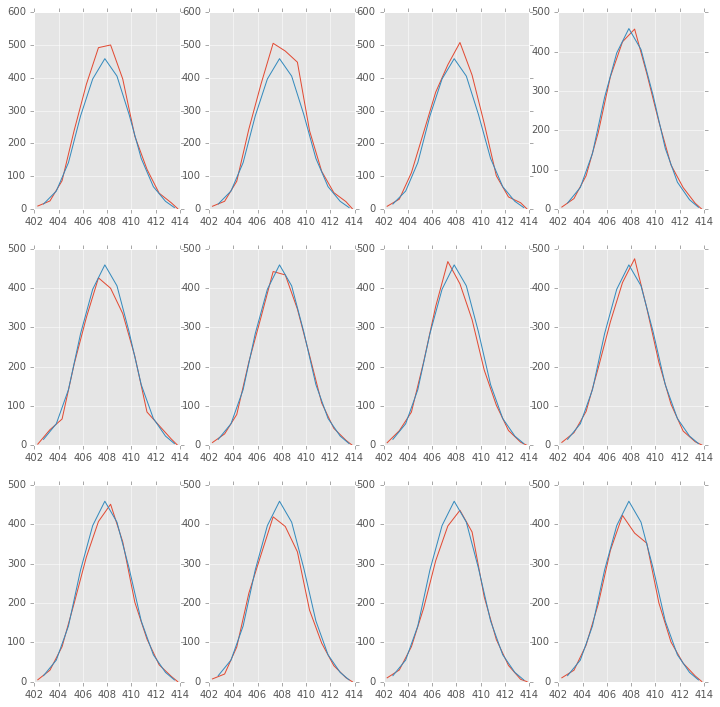

In [619]:
scan_pmtwf(pmap)

In [567]:
s2p = s2pmap[4]
len(s2p)

1

In [568]:
pmap = s2p[0]
len(pmap)

12

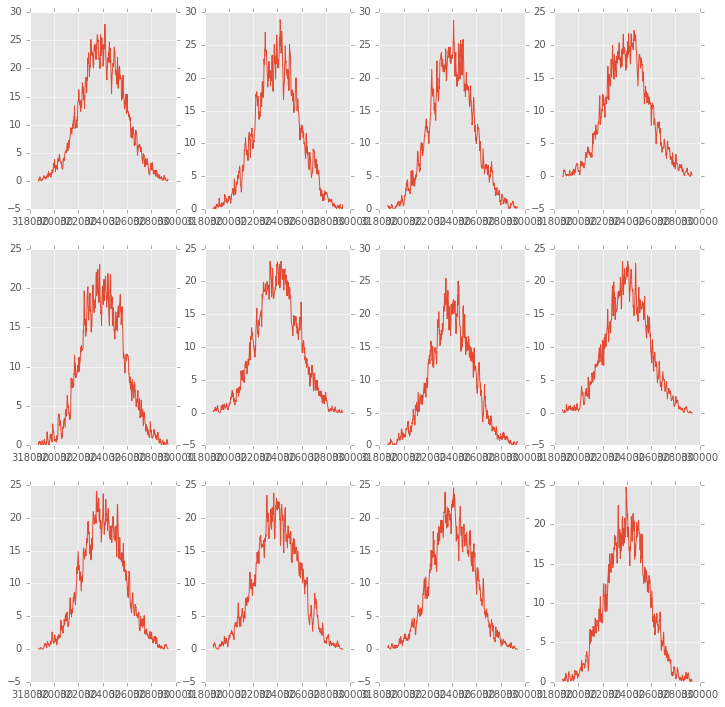

In [569]:
scan_pmtwf(pmap)

In [620]:
s2s = pd.Series(s2pmap)

In [621]:
s2s.index

RangeIndex(start=0, stop=5, step=1)

In [622]:
s2s.values

array([ [[         ene_pes  indx    time_ns
0     300.824610  5167  129160.00
1    2493.897859  5187  130162.50
2    9231.576788  5207  131162.50
3   16825.168748  5227  132162.50
4   15652.841231  5247  133162.50
5    7251.496066  5267  134162.50
6    1508.443105  5287  135162.50
7     198.258158  5307  136816.25
8     780.336038  5327  138587.50
9    2277.601430  5347  139587.50
10   3566.147695  5367  140587.50
11   2931.271633  5387  141587.50
12   1254.432895  5407  142587.50
13    217.173645  5436  143450.00,         ene_pes  indx   time_ns
0     28.135262  5166  129137.5
1    223.256697  5186  130137.5
2    817.881391  5206  131137.5
3   1588.513360  5226  132137.5
4   1482.129170  5246  133137.5
5    689.466676  5266  134137.5
6    159.396214  5286  135137.5
7      8.844864  5306  136137.5
8      4.622064  5326  137137.5
9     32.371071  5346  138137.5
10   149.576877  5366  139137.5
11   304.036935  5386  140137.5
12   294.611826  5406  141137.5
13   195.163870  5426  142137.5

In [623]:
dst = pd.HDFStore('../../data/Na/WF_Na_test_DST.h5') 

In [624]:
dst['s2pmap'] = s2s

In [626]:
dst.close()

In [649]:
pdst = pd.HDFStore('../../data/Na/WF_Na_test_DST.h5')
ps2map = pdst['s2pmap']
s2pmap_ = ps2map.values
print('events in pmap = {}'.format(len(s2pmap_)))
event=2
s2p = s2pmap_[event]
print('number of s2 in event {} = {}'.format(event,len(s2p)))
pmap = s2p[0]
print('length of  pmap = {}'.format(len(pmap)))

events in pmap = 5
number of s2 in event 2 = 1
length of  pmap = 13


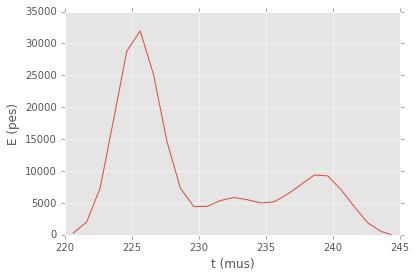

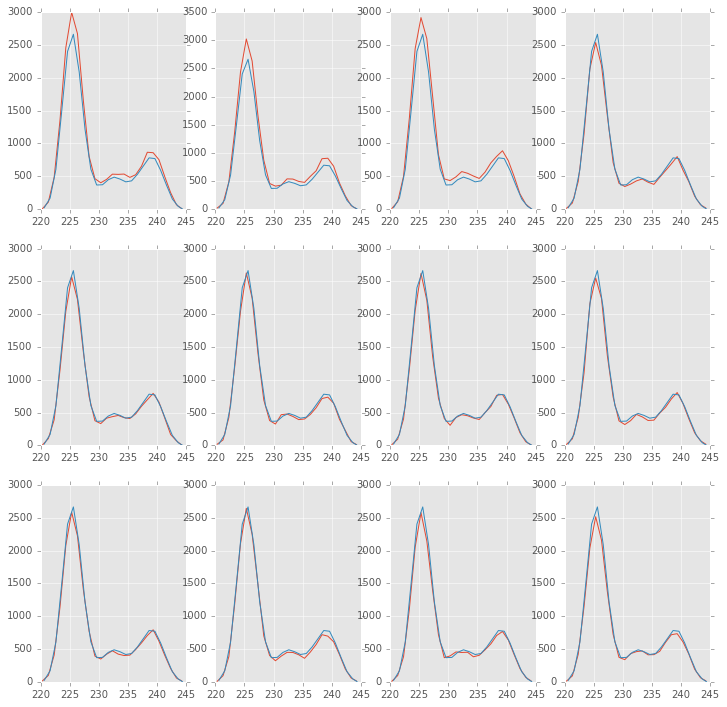

In [648]:
scan_pmtwf(pmap)

In [650]:
s2 = pmap[0]

In [651]:
len(s2)

25

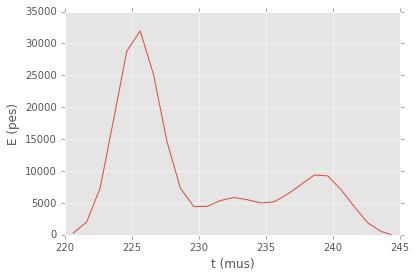

In [652]:
plt.plot(s2['time_ns']/mus,s2['ene_pes'])    
plt.xlabel('t (mus)')
plt.ylabel('E (pes)')

In [653]:
sipmrwf = h5f.root.RD.sipmrwf

In [654]:
sipmrwf

/RD/sipmrwf (EArray(10, 1792, 600), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 218, 600)

In [656]:
sipmwf = sipmrwf[event]

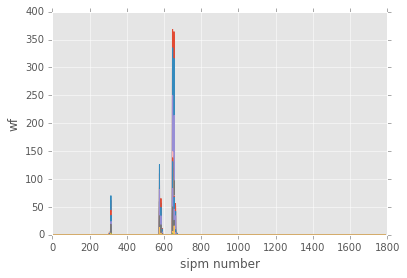

In [660]:
plt.plot(sipmwf)    
plt.xlabel('sipm number')
plt.ylabel('wf')

In [663]:
sipmwf.shape

(1792, 600)

In [676]:
def wfmus(wfns):
    swf = {}
    swf['time_mus'] = wfns['time_ns']/mus
    swf['ene_pes'] = wfns['ene_pes'] 
    swf['indx'] = wfns['indx']
    return pd.DataFrame(swf)

In [743]:
def sipm_panel(sipmrwf, event_number=0):
    """
    Returns a pandas panel for the SiPms
    """
    sipmwf = sipmrwf[event_number]
    SIPM = {}
    NSIPM = sipmwf.shape[0]
    sipmwl = sipmwf.shape[1]
    for i in range(NSIPM):
        energy_pes = sipmwf[i]
        time_ns = np.array(range(sipmwl))*1e+3 #steps are mus
        indx = np.ones(sipmwl)*i
        SIPM[i] = wfmus(wfdf(time_ns,energy_pes,indx))
    return pd.Panel(SIPM)

In [744]:
sipmp = sipm_panel(sipmrwf, event_number=event)

In [745]:
sipmp

<class 'pandas.core.panel.Panel'>
Dimensions: 1792 (items) x 600 (major_axis) x 3 (minor_axis)
Items axis: 0 to 1791
Major_axis axis: 0 to 599
Minor_axis axis: ene_pes to time_mus

In [746]:
sipmp.shape

(1792, 600, 3)

In [747]:
sipmp.major_axis

RangeIndex(start=0, stop=600, step=1)

In [748]:
sipmp.minor_axis

Index([u'ene_pes', u'indx', u'time_mus'], dtype='object')

In [749]:
sipmp.items

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791],
           dtype='int64', length=1792)

In [750]:
s2mus = wfmus(s2)

In [751]:
s2mus.time_mus.values

array([ 220.605 ,  221.6125,  222.6125,  223.6125,  224.6125,  225.6125,
        226.6125,  227.6125,  228.6125,  229.6125,  230.6125,  231.6125,
        232.6125,  233.6125,  234.6125,  235.6125,  236.6125,  237.6125,
        238.6125,  239.6125,  240.6125,  241.6125,  242.6125,  243.6125,
        244.325 ])

In [752]:
sipm =sipmp[0]

In [713]:
s2ti = s2mus.time_mus.values[0]
s2tf = s2mus.time_mus.values[-1]

In [714]:
s2ti

220.60499999999999

In [715]:
s2tf

244.32499999999999

In [727]:
def sipm_s2(sipm, s2df):
    """
    Returns a DF with the sipm values in the range specified by s2
    """
    s2ti = s2df.time_mus.values[0]
    s2tf = s2df.time_mus.values[-1]
    dfl = sipm.loc[lambda df: df.time_mus.values >= s2ti, :]
    dfu = dfl.loc[lambda df: df.time_mus.values < s2tf, :]
    return dfu


In [768]:
def sipmp_s2(sipmp, s2df, thr=0.5*pes):
    """
    Returns a panel with the sipms with energy above threshold
    """
    SIPM={}
    j=0
    for i in sipmp.items:
        sipm = sipmp[i]
        sipms2 = sipm_s2(sipm, s2df)
        if np.sum(sipms2).ene_pes > thr:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM)
    

In [769]:
sipms2p  = sipmp_s2(sipmp, s2mus, thr=0.5*pes)

In [770]:
sipms2p

<class 'pandas.core.panel.Panel'>
Dimensions: 31 (items) x 24 (major_axis) x 3 (minor_axis)
Items axis: 0 to 30
Major_axis axis: 221 to 244
Minor_axis axis: ene_pes to time_mus

In [771]:
sipms2 = sipm_s2(sipm,s2mus)

In [772]:
def sipm_hit_index(sipmp):
    hi =[]
    for i in sipmp.items:
        sipm = sipmp[i]
        hi.append(sipm.indx.values[0])
    return pd.Series(hi)

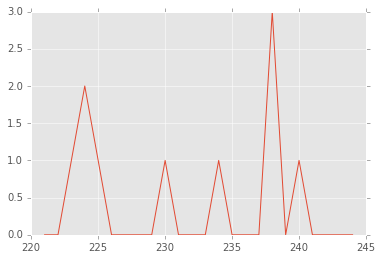

In [773]:
plt.plot(sipms2p[0].time_mus.values,sipms2p[0].ene_pes.values)

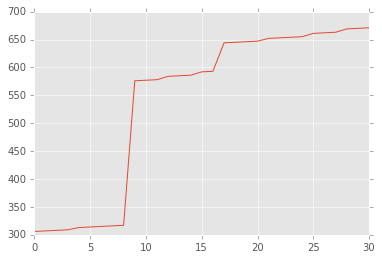

In [774]:
plt.plot(sipm_hit_index(sipms2p).values)

In [ ]:
def PMAPS(pmtcwf,sipmrwf,pmtDF,list_of_events=[0], thr = 2, stride=40):
    """
    computes pmaps in the EP plane
    """
    NPMT = len(pmtDF)
    S2PMAP = []
    for event in list_of_events:
        # compute the sum function (swf), supress zeros (swf_zs) and finds s12 for swf_zs
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        swf_zs = wf_thr(swf,threshold =thr)
        s12 = find_S12(swf_zs, stride=stride)
        
        is2=0
        if len(s12) > 1:  #if s1 exists is s12[0]
            is2=1  #s2 starts in index 1 if s1 exists in 0 otherwise
        
        S2L = []
        for s2 in s12[is2:]: #loop over s2 found is swf_zs
            PMTWF = pmt_wf(cwfdf,PMT) #wf for each of the PMTs
            #scan_pmtwf_s2(PMTWF,s2)
            
            PMAP = []
            s2rb = rebin_waveform(s2, stride = 40)
            PMAP.append(s2rb)
            for i in range(NPMT):
                pmtwf = PMTWF[i]
                pmtdf = wfdf(pmtwf.time_ns.values[s2.indx.values[0]:s2.indx.values[-1]+1], 
                                 pmtwf.ene_pes.values[s2.indx.values[0]:s2.indx.values[-1]+1],
                                 pmtwf.indx.values[s2.indx.values[0]:s2.indx.values[-1]+1])
                pmtrb = rebin_waveform(pmtdf, stride = 40)
                
                PMAP.append(pmtrb)
            S2L.append(PMAP)
        S2PMAP.append(S2L)
    return S2PMAP
                       

In [ ]:
def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]